In [19]:
%matplotlib inline

In [20]:
"""
Training data generator for Framebot V1.01.

You'll need to update the file locations for the output. This is a demonstration
project - so some functions may have not been used but have been left in place.

Not the best code - but did what it needed at the time.
"""

"\nTraining data generator for Framebot V1.01.\n\nYou'll need to update the file locations for the output. This is a demonstration\nproject - so some functions may have not been used but have been left in place.\n\nNot the best code - but did what it needed at the time.\n"

In [21]:
import numpy as np
import os
import io
import unittest
import random
import copy
import glob
import tensorflow as tf

# needed for render functions
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Rectangle, PathPatch

In [22]:
# Hyperparameters for building generator
"""
You can update these - although I have not tested if it will break the model.
Updating will require changes to the model for input and outputs - they are hard 
coded.
"""

X_BAYS = 5    # max width in X-axis
Z_BAYS = 5    # max width in Z-axis
Y_BAYS = 5    # max height in Y-axis

GRID_BAYS = X_BAYS + Z_BAYS

MIN_BLDG_DIM = 3  # minimum segments for the building width in X and Z grids
MIN_BLDG_HEIGHT = 1 # minimum segments for building height in Y-axis grids

FRAME_TYPES = ['braced', 'shear_wall']

In [23]:
def gen_arch_floor_plans(floor, width=MIN_BLDG_DIM, length=MIN_BLDG_DIM, c_length=0, c_width=0, t_length=0, t_width=0, btype=0):
    """
    Function generates a floor plate
    Note -> this function is tested

    Input:
    floor: floor plate array from arch_array
    width: building width -> y-axis
    length: building length -> x-axis
    c_length: corner y-axis dimension
    c_width: corner x-axis dimension
    t_length: t y-axis dimension
    t_width: full (both sides) width reduction to split in x-axis dimension
    btype: integer to determine building type
          0: retangular, 1: 'L', 2: 'T'

    Output:
    floor: with array cells updated with 2 (solid space) where there is floor
    """
    btype = btype
    _floor = floor.copy()
    
    # check dimension limits
    if width > _floor.shape[1]:
        width = _floor.shape[1]

    if length > _floor.shape[0]:
        length = _floor.shape[0]

    if btype == 0:
        # generate rectangular floor dimensions
        # update floor array
        for y in range(length):
            for x in range(width):
                _floor[x][y] = 2
    elif btype == 1:
        # generate an L-shaped floor
        # update floor array all solid
        _floor.fill(2)
        # carve out corner - always from same origin
        # update floor array
        for y in range(c_length):
            for x in range(c_width):
                _floor[x][y] = 0
    elif btype == 2:
        # generate an T-shaped floor
        # update floor array all solid
        _floor.fill(2)
        # carve out a random sized ends - always from same origin
        # split width and take care of odd splits
        if t_width % 2 == 0:
            width1 = width2 = int(t_width / 2)
        else:
            width1 = 1
            width2 = t_width - width1 

        # update floor array
        for y in range(t_length):
            for i in range(width1):
                _floor[i][y] = 0
            
            col_width2 = _floor.shape[0] - 1
            for j in range(width2):
                _floor[col_width2][y] = 0
                col_width2 -= 1
    else:
        raise ValueError('Building type out of range')

    return _floor

In [24]:
def map_interior_columns(floor):
    """
    Function is a helper function to map the interior columns into an array
    so it is easier to assign in the generator

    Input:
    floor: floor array

    Output:
    col_map: an array with 1's where the interior columns go and 0's otherwise
    """
    x_dim = floor.shape[1]
    y_dim = floor.shape[0]
    col_map = np.zeros_like(floor)

    for i in range(y_dim):
        if i != 0 and i != (y_dim-1):
            for j in range(x_dim):
                if j != 0 and j != (x_dim-1):
                    if floor[i][j] == 2:
                        check_1 = floor[(i-1)][j]
                        check_2 = floor[(i+1)][j]
                        check_3 = floor[i][(j-1)]
                        check_4 = floor[i][(j+1)]
                        check_5 = floor[(i-1)][(j-1)]
                        check_6 = floor[(i-1)][(j+1)]
                        check_7 = floor[(i+1)][(j-1)]
                        check_8 = floor[(i+1)][(j+1)]
                        if check_1==check_2==check_3==check_4==check_5==check_6==check_7==check_8==2:
                            col_map[i][j] = 1
                        else:
                            col_map[i][j] = 0
                else:
                    col_map[i][j] = 0

    return col_map

In [25]:
def wall_mapper(floor):
    """
    Function is a helper function to map the perimeter walls into an array
    so it is easier to assign in the wall generator

    Input:
    floor: floor array

    Output:
    wall_map: an array with 1's where the exterior walls go and 0's otherwise
    """
    x_dim = floor.shape[1]
    y_dim = floor.shape[0]
    wall_base = []

    for i in range(y_dim):
        wall = np.zeros(x_dim)
        for j in range(x_dim):
            if i == 0 or i == (y_dim-1):
                if floor[i][j] == 2:
                    wall[j] = 1
            if i != 0 and i != (y_dim-1) and floor[i][j]==2:
                check_1 = floor[(i-1)][j]
                check_2 = floor[(i+1)][j]
                if j == 0:
                    if check_1==0 or check_2==0:
                        wall[j] = 1
                elif j == (x_dim-1):
                    if check_1==0 or check_2==0:
                        wall[j] = 1
                elif j != 0 and j != (x_dim-1):
                    # eliminate perpindicular walls
                    if check_1==0 or check_2==0:
                        wall[j] = 1
                else:
                    raise ValueError('j out of range')        
        wall_base.append(wall)    

    wall_base = np.array(wall_base)
    return wall_base

In [26]:
def gen_arch_wall_elevs(floor_map, height):
    """
    Function generates wall panels for arch_array

    Input:
    floor_map: floor map

    Output:
    elev_grids: 3-d array updated with 0, 1, 2 values based on wall type and 
                grid layer. keeps solids aligned

    NOTE: ***** no unit test for this - uses random for output ********
    """
    grid_layers = GRID_BAYS
    x_dim = floor_map.shape[1]
    y_dim = floor_map.shape[0]
    wall_elev_base = []
    elev_grids = []

    # generate base elevations from wall_map
    # x-grid
    wall_elev = wall_mapper(floor_map)

    # z-grid
    z_floor_map = np.rot90(floor_map, k=1)
    z_floor_map = np.flipud(z_floor_map)
    wall_elev_z = wall_mapper(z_floor_map)
    wall_elev = np.concatenate((wall_elev, wall_elev_z), axis=0)

    # generate elevations by copying base down all floor levels
    for layer in wall_elev:
        elev = np.zeros((x_dim), dtype=int)
        brace_count = 0
        for i in range(elev.shape[0]):
            if layer[i]==1:
                wall_type = random.randint(1, 2)  # ***********UPDATE FOR MORE THAN TWO WALL TYPES
                if brace_count == 0:
                    elev[i] = wall_type
                    if wall_type == 2:
                        brace_count +=1
                elif i == (elev.shape[0]-1) and brace_count == 0:
                    elev[i] = 2
                else:
                    elev[i] = 1
        elev = np.tile(elev, ((height), 1))
        for j in range(Y_BAYS):
            if j >= height:
                elev_empty = np.zeros((x_dim), dtype=int)
                elev = np.vstack([elev, elev_empty])
        elev_grids.append(elev)
        
    elev_grids = np.array(elev_grids)
    
    return elev_grids

In [27]:
def gen_arch_columns(col_map):
    """
    Function generates columns for arch_array

    Input:
    col_map: array with interior grid bay locations

    Output:
    column_loc: array with 1's for columns. Future update may offer different
                column types i.e. 1's for steel, 2's for concrete, etc.
    """
    col = col_map
    return col

In [28]:
def gen_dims(floor, bldg_type):
    """
    V1.01 Update:
     - changed dimension to output 0 if under 30 ft and 1 if over 30 ft
     - layers deal with x and z grids using 0 or 1 for dimensions (see above)
    =======================================================
    Function to generate ratio of x to z grid dimensions based on framing
    system used - min value always would be divided by max value

    Input:
    floor: floor array - just for dimensions
    bldg_type: sets the ratios to be generated

    Output:
    x_ratio: array of ratios based on bldg_type
    z_ratio: array of ratios based on bldg_type
    """
    x_ratio = 1.0
    z_ratio = 1.0
    major_axis =  random.randint(0, 1)

    # generate ratios based on building type
    if bldg_type == 0:
        # V1.01 update
        x_ratio = 0
        z_ratio = 0
        """
        if major_axis==0:
            x_ratio = random.uniform(0.5, 0.7)
        else:
            z_ratio = random.uniform(0.5, 0.7)
        """
    elif bldg_type == 1:
        # V1.01 update
        x_ratio = 1
        z_ratio = 1
        """
        if major_axis==0:
            x_ratio = random.uniform(0.8, 1.0)	
        else:
            z_ratio = random.uniform(0.8, 1.0)
        """
    else:
        raise ValueError('Building type out of range')
    
    return x_ratio, z_ratio

In [29]:
def gen_arch_bldg(x, y, z, bldg_type, num_bldg_types=2):
    """
    Function to generate a random arch building model. 

    Input:
    x: x dimension - width
    y: y dimension - number floors
    z: z dimension - length
    bldg_type: 0-braced, 1-shearwall

    Output:
    arch_array: array cells updated with values to generate building model
    """
    # generate random floor plan
    floor = np.zeros((z, x))        # floor plate array
    ftype = random.randint(0, 2)
    width = random.randint(MIN_BLDG_DIM, x)
    length = random.randint(MIN_BLDG_DIM, z)
    c_length = 0
    c_width = 0
    t_length = 0
    t_width = 0
    btype = bldg_type
    if ftype !=0:
        # check buiding dimensions
        check_x = width - MIN_BLDG_DIM
        check_z = length - MIN_BLDG_DIM
        # set max cut dimensions
        if check_x > 0:
            c_width = random.randint(1, 2)
            t_width = random.randint(1, 2)
        if check_z > 0:
            c_length = random.randint(1, 2)
            t_length = random.randint(1, 2)

    typ_floor = gen_arch_floor_plans(floor, width, length, c_length, c_width, t_length, t_width, ftype)

    # generate floors
    floor_array = []
    for i in range(GRID_BAYS):
        if i > 0 and i <= y:
            floor_array.append(typ_floor)
        else:
            _floor = np.zeros((z, x))
            floor_array.append(_floor)
    floor_array = np.array(floor_array)

    # validate building dimensions from typ_floor
    _width = (np.sum(typ_floor, axis=1).max())//2
    _length = (np.sum(typ_floor, axis=0).max())//2

    # generate a map of interior column locations
    col_map = map_interior_columns(typ_floor)

    # generate wall elevations
    elev = gen_arch_wall_elevs(typ_floor, y)

    # generate columns
    col = gen_arch_columns(col_map)
    # generate floors
    col_array = []
    for i in range(GRID_BAYS):
        if i < y:
            col_array.append(col)
        else:
            _floor = np.zeros((z, x))
            col_array.append(_floor)
    col_array = np.array(col_array)

    # add dimension layers for x and z ratios
    # generate dimension ratios
    _typ_floor = floor_array[0]
    x_ratio, z_ratio = gen_dims(_typ_floor, bldg_type)

    # generate empty arch_array
    array_columns = elev.shape[1] + floor_array.shape[1] + col_array.shape[1]
    array_rows = Y_BAYS
    array_depth_3d = GRID_BAYS + 2 + 2  # note: 2 dimension layers and 2 type layers
    arch_array = np.zeros((array_depth_3d, array_rows, array_columns))
    
    # assemble array
    for i in range(arch_array.shape[0]):
        if i < GRID_BAYS:
            current_layer = np.concatenate((elev[i], floor_array[i], col_array[i]), axis=1)
            arch_array[i] = current_layer
        elif i < (arch_array.shape[2]-(num_bldg_types+2)):
            arch_array[i] = (arch_array[i] + 1) * x_ratio
        elif i < (arch_array.shape[2]-(num_bldg_types+1)):
            arch_array[i] = (arch_array[i] + 1) * z_ratio
        elif i < (arch_array.shape[2]-num_bldg_types):
            if bldg_type == 0:
                arch_array[i] = (arch_array[i] + 1)
        else:
            if bldg_type == 1:
                arch_array[i] = (arch_array[i] + 1)

    return arch_array  # return arch_array, _width, _length, ftype

In [30]:
def arch_render(arch_model):     # def arch_render(arch_model, scale, b_width=3, b_length=3, ftype=0):
    """
    V1.01 Update - dimensions layers are 0 for under 30ft and 1 for over 30ft
    - just render everything at the moment with 1.0
    - application sending info into model can handle ratios for final rendering
      and scale the output to actual - future feature
    """
    scale = 30 # arbitrary number
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax._axis3don = False

    # get building dimensions
    b_length = 0
    b_width = 0

    for i in range(X_BAYS):
        # count from back
        r_i = (X_BAYS - 1) - i
        walls_x = arch_model[r_i][:, 0:X_BAYS]
        is_zero = np.sum(walls_x)
        if is_zero > 0:
            b_length = (X_BAYS) - i
            break

    for i in range(Z_BAYS):
        # count from back
        r_i = ((X_BAYS + Z_BAYS) - 1) - i
        walls_z = arch_model[r_i][:, 0:X_BAYS]
        is_zero = np.sum(walls_z)
        if is_zero > 0:
            b_width = (Z_BAYS) - i
            break

    
    # extract building lateral type from model
    ftype = 0
    num = 1
    brace_bldg = arch_model[-2]
    shear_bldg = arch_model[-1]
    if num in brace_bldg:
        ftype = 0
    elif num in shear_bldg:
        ftype = 1
    else:
        raise ValueError('lat_type out of range')

    # extract dimension ratios
    # V1.01 update

    """
    arch_x_dim_ratio = arch_model[-4]
    arch_z_dim_ratio = arch_model[-3]
    x_ratio = arch_x_dim_ratio[0][0]
    z_ratio = arch_z_dim_ratio[0][0]
    
    x_dim = x_ratio * scale
    z_dim = z_ratio * scale
    """
    x_dim = scale  # just use scale here
    z_dim = scale
    y_dim = 0.5 * scale
    
    x_limit = x_dim * Z_BAYS
    z_limit = z_dim * X_BAYS
    y_limit = y_dim * Y_BAYS

    ax.set_xlim(0, x_limit)
    ax.set_ylim(0, z_limit)
    ax.set_zlim(0, y_limit)

    # adjustment for T buildings
    adj_width = 0
    adj_length = 0
    
    if ftype == 0:
        adj_width = 3
        adj_length = 3
    else:
        adj_width = 3
        adj_length = 3

    # draw walls in x-axis
    grid = 0
    for i in range(X_BAYS):
        # anchor point coordinates
        height = y_dim
        width = x_dim
        if b_length == 3:
            adj_length = 1
        if i < (adj_length):
            grid = z_dim * i
        else:
            grid = z_dim * (i + 1)
        
        a_x = 0
        a_y = 0
        for j in range(Y_BAYS):
            a_x = 0
            a_y = height * j
            for k in range(X_BAYS):
                a_x = width * k
                if arch_model[i][j][k]==1:
                    wall = Rectangle((a_x, a_y), width, height, facecolor='blue', edgecolor='black', alpha=0.2)
                    ax.add_patch(wall)
                    art3d.pathpatch_2d_to_3d(wall, z=grid, zdir="y")
                elif arch_model[i][j][k]==2:
                    wall = Rectangle((a_x, a_y), width, height, facecolor='orange', edgecolor='black', alpha=0.2)
                    ax.add_patch(wall)
                    art3d.pathpatch_2d_to_3d(wall, z=grid, zdir="y")
                else:
                    if arch_model[i][j][k]==0:
                        pass
                    else:
                        raise ValueError('wall render wall type out of range')
       

    # draw walls in z-axis
    grid = 0
    for z in range(Z_BAYS):
        # shift i to z elevation layers
        i = X_BAYS + z
        if b_width == 3:
            adj_width = 1
        if z < (adj_width):   #b_width-adj
            grid = x_dim * z
        else:
            grid = x_dim * (z + 1)

        height = y_dim
        width = z_dim
        a_x = 0
        a_y = 0
        for j in range(Y_BAYS):
            a_x = 0
            a_y = height * j
            for k in range(Z_BAYS):
                a_x = width * k
                if arch_model[i][j][k]==1:
                    wall = Rectangle((a_x, a_y), width, height, facecolor='green', alpha=0.2)
                    ax.add_patch(wall)
                    art3d.pathpatch_2d_to_3d(wall, z=grid, zdir="x")
                elif arch_model[i][j][k]==2:
                    wall = Rectangle((a_x, a_y), width, height, facecolor='red',  alpha=0.2)
                    ax.add_patch(wall)
                    art3d.pathpatch_2d_to_3d(wall, z=grid, zdir="x")
                else:
                    if arch_model[i][j][k]==0:
                        pass
                    else:
                        raise ValueError('wall render wall type out of range')
    
    # Draw floor plates
    grid = 0
    for i in range(Y_BAYS + 1):
        # anchor point coordinates
        width = x_dim
        length = z_dim
        grid = y_dim * i
        a_x = 0
        a_y = 0
        for j in range(Y_BAYS):
            a_x = 0
            a_y = length * j
            for z in range(X_BAYS):
                # shift k to floor plate columns
                k = X_BAYS + z
                a_x = width * z
                if arch_model[i][j][k]==2:
                    wall = Rectangle((a_x, a_y), width, length, facecolor='pink', edgecolor='black', alpha=0.2)
                    ax.add_patch(wall)
                    art3d.pathpatch_2d_to_3d(wall, z=grid, zdir="z")
                else:
                    if arch_model[i][j][k]==0:
                        pass
                    else:
                        raise ValueError('wall render wall type out of range')
    
    # Draw columns
    grid = 0
    for i in range(Y_BAYS):
        # anchor point coordinates
        width = x_dim
        length = z_dim
        
        grid = y_dim * (i + 1)
        a_x = 0
        a_y = 0
        for j in range(Z_BAYS):
            a_x = 0
            a_y = length * j
            for z in range(X_BAYS):
                # shift k to floor plate columns
                k = 2 * X_BAYS + z
                a_x = width * z
                if arch_model[i][j][k]==1:
                    x_bot = x_top = a_x
                    y_bot = y_top = a_y
                    z_bot = i * y_dim
                    z_top = (i + 1) * y_dim
                    col = art3d.Line3D((x_bot, x_top), (y_bot, y_top), (z_bot, z_top), color='black')
                    ax.add_line(col)
                    # add column to right-most gridline -> bay to gridline adjustment
                    if z < (X_BAYS - 1):
                        # check next column for zero
                        if arch_model[i][j][(k+1)]==0:
                            x_bot = x_top = width * (z + 1)
                            y_bot = y_top = a_y
                            z_bot = i * y_dim
                            z_top = (i + 1) * y_dim
                            col = art3d.Line3D((x_bot, x_top), (y_bot, y_top), (z_bot, z_top), color='black')
                            ax.add_line(col)
                    # expand column line to last gridline -> bay to gridline adjustment
                    if j <= (Z_BAYS + 1):
                        # check row below for zero
                        if arch_model[i][(j+1)][k]==0:
                            x_bot = x_top = a_x
                            y_bot = y_top = length * (j + 1)
                            z_bot = i * y_dim
                            z_top = (i + 1) * y_dim
                            col = art3d.Line3D((x_bot, x_top), (y_bot, y_top), (z_bot, z_top), color='black')
                            ax.add_line(col)
                    # expand to catch diagonal
                    if z < (X_BAYS - 1) and j <= (Z_BAYS + 1):
                        # check row below for zero
                        if arch_model[i][(j+1)][(k+1)]==0:
                            x_bot = x_top = width * (z + 1)
                            y_bot = y_top = length * (j + 1)
                            z_bot = i * y_dim
                            z_top = (i + 1) * y_dim
                            col = art3d.Line3D((x_bot, x_top), (y_bot, y_top), (z_bot, z_top), color='black')
                            ax.add_line(col)

                
    plt.show()

In [31]:
def gen_struct_bldg(arch_array):
    """
    V1.01 Update:
    - removing dimensional data from array - not needed except for
      extracting lateral type
    - walls need to be placed in own columns for 1 or zero value to eliminate
      the need for scaling (one hot encoding needed)

    =====================================
    Function to generate a structural building model. 

    Input:
    arch_array: architectural building model
    bldg_type: 0-braced, 1-shearwall

    Output:
    struct_array: array cells updated with values to generate building model
    """
    # build structural array from arch_array: col grids, beams, lateral, floor, dims
    # columns:  column grids (X+1) - beams (X+1) - braces (X) - floor (X) 
    # V1.01 UPDATE ===>                                     add columns => walls (X)
    struct_array_columns = 2* (X_BAYS + 1) + 3 * (X_BAYS)  # V1.01 UPDATE 2*(X_BAYS) ==> 3*(X_BAYS)
    struct_array_rows = Y_BAYS
    # V1.01 ==> removed the 2 dimension layers below in struct_array_layers
    stuct_array_layers = (X_BAYS + 1) + (Z_BAYS + 1)  # V1.01 ==> extra dim layers: x_ratio, z_ratio REMOVED
    struct_array = np.zeros((stuct_array_layers, struct_array_rows, struct_array_columns))

    # extract building lateral type from model
    lat_type = 0
    num = 1
    brace_bldg = arch_array[-2]
    shear_bldg = arch_array[-1]
    if num in brace_bldg:
        lat_type = 0
    elif num in shear_bldg:
        lat_type = 1
    else:
        raise ValueError('lat_type out of range')

    # extract dimension ratios
    """
    V1.01 update
    <revised> - removed below

    arch_x_dim_ratio = arch_array[-4]
    arch_z_dim_ratio = arch_array[-3]
    x_ratio = arch_x_dim_ratio[0][0]
    z_ratio = arch_z_dim_ratio[0][0]
    """

    # structural array offsets
    beam_offset = X_BAYS + 1
    lat_offset = 2 * X_BAYS + 2
    floor_offset = 3 * X_BAYS + 2
    wall_offset = 4 * X_BAYS + 2   # V1.01 UPDATE - added

    # get building dimensions
    b_length = 0
    b_width = 0

    for i in range(X_BAYS):
        # count from back
        r_i = (X_BAYS - 1) - i
        walls_x = arch_array[r_i][:, 0:X_BAYS]
        is_zero = np.sum(walls_x)
        if is_zero > 0:
            b_length = (X_BAYS) - i
            break

    for i in range(Z_BAYS):
        # count from back
        r_i = ((X_BAYS + Z_BAYS) - 1) - i
        walls_z = arch_array[r_i][:, 0:X_BAYS]
        is_zero = np.sum(walls_z)
        if is_zero > 0:
            b_width = (Z_BAYS) - i
            break
    
    # adjustment for T buildings
    adj_width = 0
    adj_length = 0
    
    if lat_type == 0:
        adj_width = b_width - 1
        adj_length = b_length - 1
        
    else:
        adj_width = 3
        adj_length = 3
 
    # generate columns ==================  
    for j in range(X_BAYS):
        floor_map = arch_array[(j+1)][:, X_BAYS:(X_BAYS * 2)]
        for i in range(Z_BAYS):
            for k in range(X_BAYS):
                if floor_map[i][k] !=0:
                    if k == 0:
                        # columns
                        struct_array[i][j][k] = 1
                    if k < (X_BAYS-1):   # was just if
                        # columns
                        struct_array[i][j][k] = 1
                        struct_array[i][j][(k+1)] = 1
                        struct_array[(i+1)][j][k] = 1
                        struct_array[(i+1)][j][(k+1)] = 1
                    elif k == (X_BAYS-1):
                        # columns
                        struct_array[i][j][(k+1)] = 1
                        struct_array[(i+1)][j][(k+1)] = 1
                    else:
                        raise ValueError('k out of range')
    
    # generate beams =========================
    if lat_type == 0:
        # x-grids
        for i in range(X_BAYS+1):
            for j in range(Y_BAYS):
                for k in range(X_BAYS):
                    if struct_array[i][j][k] == 1 and struct_array[i][j][(k+1)] == 1:
                        # beam
                        struct_array[i][j][(k + beam_offset)] = 1
        
        # z grids
        for i in range(X_BAYS):
            grid_offset = (X_BAYS+1) + i 
            for j in range(Y_BAYS):
                for k in range(X_BAYS+1):
                    if struct_array[i][j][k] == 1 and struct_array[i+1][j][k] == 1:
                        # beam
                        struct_array[grid_offset][j][(k + beam_offset)] = 1
                             
    # generate floor plates ==================  
    for i in range(X_BAYS+1):
        i_offset = i + X_BAYS
        floor_map = arch_array[i][:, X_BAYS:(X_BAYS * 2)]
        for j in range(Y_BAYS):
            for k in range(X_BAYS):
                z = k + floor_offset
                if floor_map[j][k] == 2:
                    # floors
                    struct_array[i][j][z] = 1
    
    # generate lateral bay designations =========
    if lat_type == 0:
        # x-grid brace
        for i in range(X_BAYS):
            if i < adj_length:
                grid = i
            else:
                grid = i + 1
            for j in range(Y_BAYS):
                for k in range(X_BAYS):
                    if arch_array[i][j][k] == 2:
                        z = k + lat_offset
                        struct_array[grid][j][z] = 1
                        
        
        # z-grid brace
        for i in range(Z_BAYS):
            i_shift = X_BAYS + i
            if i < adj_width:
                grid = i + (X_BAYS + 1)
            else:
                grid = (i + 2) + X_BAYS
            for j in range(Y_BAYS):
                for k in range(X_BAYS):
                    if arch_array[i_shift][j][k] == 2:
                        z = k + lat_offset
                        struct_array[grid][j][z] = 1
                        
    # general walls ====================================
    if lat_type == 1:
        # x-grid walls
        adj = 0
        for i in range(X_BAYS):
            adj = adj_length
            if b_length == 3:
                adj = 1
            if i < adj:
                grid = i
            else:
                grid = i + 1
            for j in range(Y_BAYS):
                for k in range(X_BAYS):
                    if arch_array[i][j][k] == 2:
                        z = k + wall_offset        #V1.01 UPDATE
                        struct_array[grid][j][z] = 1
                        # remove adjacent columns -> UPDATE FUTURE
                        # struct_array[grid][j][k] = 0
                        # struct_array[grid][j][k+1] = 0
                        
        
        # z-grid walls
        adj = 0
        for i in range(Z_BAYS):
            i_shift = X_BAYS + i
            adj = adj_width
            if b_width == 3:
                adj = 1
                i_rc = 1
            if i < adj:
                grid = i + (X_BAYS + 1)
                i_rc = i
            else:
                grid = (i + 2) + X_BAYS
                i_rc = i + 1
            for j in range(Y_BAYS):
                for k in range(X_BAYS):
                    if arch_array[i_shift][j][k] == 2:
                        z = k + wall_offset       #V1.01 UPDATE
                        struct_array[grid][j][z] = 1
                        # remove adjacent columns -> UPDATE FUTURE
                        # struct_array[i_rc][j][k] = 0
                        #struct_array[i_rc + 1][j][k] = 0

        # V1.01 - update to shift to wall columns
        # delete columns
        for i in range(X_BAYS + Z_BAYS + 2):
            for j in range(Y_BAYS):
                for k in range(X_BAYS):
                    z = k + wall_offset           #V1.01 UPDATE
                    if struct_array[i][j][z] == 1:
                        if i < (X_BAYS + 1):
                            struct_array[i][j][k] = 0
                            struct_array[i][j][k+1] = 0
                        else:
                            i_shift = i - (X_BAYS+1)
                            struct_array[k][j][i_shift] = 0
                            struct_array[k+1][j][i_shift] = 0

    # add dimension layers to strut_array ===============
    """
    V1.01 - revision
    <revised> - removed dimensions

    struct_array[-2] = 1 * x_ratio
    struct_array[-1] = 1 * z_ratio
    """

    return struct_array

In [32]:
def struct_render(struct_model):
    """
    V1.01 - revision
    - removed x and z scale ratio so just multiply by 1 and scale
    - walls are offset to new columns - adjust renderer to grab info
    """
    scale = 30 # arbitrary number
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax._axis3don = False

    # extract dimension ratios
    """
    V1.01 - revision
    <removed>

    x_dim_ratio = struct_model[-2]
    z_dim_ratio = struct_model[-1]
    x_ratio = x_dim_ratio[0][0]
    z_ratio = z_dim_ratio[0][0]

    x_dim = x_ratio * scale
    z_dim = z_ratio * scale
    """
    x_dim = scale     # V1.01  update
    z_dim = scale     # V1.01  update
    y_dim = 0.5 * scale
    
    x_limit = x_dim * (Z_BAYS + 1)
    z_limit = z_dim * (X_BAYS + 1)
    y_limit = y_dim * Y_BAYS

    ax.set_xlim(0, x_limit)
    ax.set_ylim(0, z_limit)
    ax.set_zlim(0, y_limit)

    # structural array offsets
    beam_offset = X_BAYS + 1
    lat_offset = 2 * X_BAYS + 2
    floor_offset = 3 * X_BAYS + 2
    wall_offset = 4 * X_BAYS + 2     # V1.01  update

    # Draw columns =========================================
    for i in range(X_BAYS+1):
        # anchor point coordinates
        a_y = 0
        for j in range(Y_BAYS):
            a_x = 0
            a_y = y_dim * j
            a_y_top = y_dim * (j + 1)
            for k in range(X_BAYS+1):
                a_x = x_dim * k
                if struct_model[i][j][k] != 0:
                    x_bot = x_top = a_x
                    y_bot = y_top = z_dim * i
                    z_bot = a_y
                    z_top = a_y_top
                    col = art3d.Line3D((x_bot, x_top), (y_bot, y_top), (z_bot, z_top), color='black', alpha=0.4)
                    ax.add_line(col)
    
    # Draw beams ==============================================
    # x-axis beams
    grid = 0
    for i in range(X_BAYS+1):
        # anchor point coordinates
        a_y = 0
        grid = z_dim * i
        for j in range(Y_BAYS):
            a_x = 0
            a_y = y_dim * (j + 1)
            for z in range(X_BAYS):
                k = beam_offset + z
                a_x = x_dim * z
                a_x_end = x_dim * (z + 1)
                if struct_model[i][j][k] != 0:
                    x_bot = a_x
                    x_top = a_x_end
                    y_bot = grid
                    y_top = grid
                    z_bot = a_y
                    z_top = a_y
                    col = art3d.Line3D((x_bot, x_top), (y_bot, y_top), (z_bot, z_top), color='purple', alpha=0.8)
                    ax.add_line(col)
    # z-axis beams
    grid = 0
    for i in range(Z_BAYS+1):
        # anchor point coordinates
        a_x = z_dim * i
        a_x_end = z_dim * (i + 1)
        for j in range(Y_BAYS):
            a_y = y_dim * (j + 1)
            for z in range(Z_BAYS+1):
                k = beam_offset + z
                grid = x_dim * z
                offset_i = i + (X_BAYS+1)
                if struct_model[offset_i][j][k] != 0:
                    x_bot = grid
                    x_top = grid
                    y_bot = a_x
                    y_top = a_x_end
                    z_bot = a_y
                    z_top = a_y
                    col = art3d.Line3D((x_bot, x_top), (y_bot, y_top), (z_bot, z_top), color='red', alpha=0.8)
                    ax.add_line(col)

    # Draw floor plates =======================================
    grid = 0
    for i in range(Y_BAYS + 1):
        # anchor point coordinates
        width = x_dim
        length = z_dim
        grid = y_dim * i
        a_y = 0
        for j in range(Y_BAYS):
            a_x = 0
            a_y = length * j
            for z in range(X_BAYS):
                # shift k to floor plate columns
                k = floor_offset + z
                a_x = width * z
                if struct_model[i][j][k]==1:
                    wall = Rectangle((a_x, a_y), width, length, facecolor='blue', alpha=0.2)
                    ax.add_patch(wall)
                    art3d.pathpatch_2d_to_3d(wall, z=grid, zdir="z")
                else:
                    if struct_model[i][j][k]==0:
                        pass
                    else:
                        raise ValueError('wall render wall type out of range')

    # Draw BRACES AND WALLS================================================
    """
    V1.01 Update:
    - split wall and braces into two different functions due to new data
      layout
    - changes too numerous -> refer to old verision to compare
    """
    grid = 0
    height = y_dim
    width = x_dim
    length = z_dim

    # X-AXIS --
    # V1.01 - Braces only
    for i in range(X_BAYS+1):
        # anchor point coordinates
        a_y = 0
        grid = z_dim * i
        for j in range(Y_BAYS):
            a_x = 0
            a_y_bot = y_dim * j
            a_y_top = y_dim * (j + 1)
            for z in range(X_BAYS):
                k = lat_offset + z
                a_x = x_dim * z
                a_x_end = x_dim * (z + 1)
                if struct_model[i][j][k] == 1:
                    x_bot = a_x
                    x_top = a_x_end
                    y_bot = grid
                    y_top = grid
                    z_bot = a_y_bot
                    z_top = a_y_top
                    col = art3d.Line3D((x_bot, x_top), (y_bot, y_top), (z_bot, z_top), color='orange', lw=2)
                    ax.add_line(col)

    # V1.01 - Walls only              
    for i in range(X_BAYS+1):
        # anchor point coordinates
        a_y = 0
        grid = z_dim * i
        for j in range(Y_BAYS):
            a_x = 0
            a_y_bot = y_dim * j
            for z in range(X_BAYS):
                k = wall_offset + z
                a_x = x_dim * z
                a_x_end = x_dim * (z + 1)
                if struct_model[i][j][k] == 1:
                    wall = Rectangle((a_x, a_y_bot), width, height, facecolor='orange', alpha=0.2)
                    ax.add_patch(wall)
                    art3d.pathpatch_2d_to_3d(wall, z=grid, zdir="y")
                
    # Z Axis --- 
    # V1.01 Braces only
    grid = 0
    for i in range(Z_BAYS+1):
        # anchor point coordinates
        a_y = 0
        grid = x_dim * i
        for j in range(Y_BAYS):
            a_x = 0
            a_y_bot = y_dim * j
            a_y_top = y_dim * (j + 1)
            for z in range(Z_BAYS):
                k = lat_offset + z
                a_x = z_dim * z
                a_x_end = z_dim * (z + 1)
                offset_i = i + (X_BAYS+1)
                if struct_model[offset_i][j][k] == 1:
                    x_bot = grid
                    x_top = grid
                    y_bot = a_x
                    y_top = a_x_end
                    z_bot = a_y_bot
                    z_top = a_y_top
                    col = art3d.Line3D((x_bot, x_top), (y_bot, y_top), (z_bot, z_top), color='green', lw=2)
                    ax.add_line(col)
                
    # Draw walls =============================================
    # z-axis
    grid = 0
    for i in range(Z_BAYS+1):
        # anchor point coordinates
        grid = x_dim * i
        a_y = 0
        # offset = (Z_BAYS+1) + i
        for j in range(Y_BAYS):
            a_x = 0
            a_y_bot = y_dim * j
            for z in range(Z_BAYS):
                offset_i = i + (X_BAYS+1)
                k = wall_offset + z
                if struct_model[offset_i][j][k] == 1:
                    a_x = z_dim * z
                    wall = Rectangle((a_x, a_y_bot), length, height, facecolor='green', alpha=0.2)
                    ax.add_patch(wall)
                    art3d.pathpatch_2d_to_3d(wall, z=grid, zdir="x")

    plt.show()

In [33]:
# Test inputs to verify generator is working

x = 5
# y = 1
y = random.randint(1, 5)
z = 5
bldg_type = random.randint(0, 1)
# bldg_type = 1
arch_array = gen_arch_bldg(x, y, z, bldg_type, num_bldg_types=2)
struct = gen_struct_bldg(arch_array)

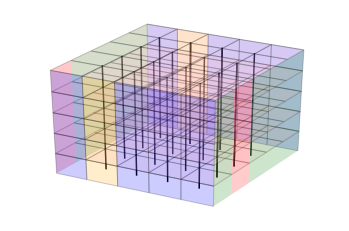

In [34]:
arch_render(arch_array)

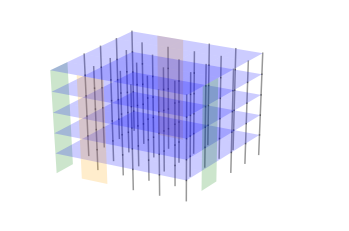

In [35]:
struct_render(struct)

# GENERATE DATA - WRITE TO FILE

In [36]:
# CHANGE THIS TO YOUR FILE LOCATION
save_file_path = '/content/drive/MyDrive/framebot/data'

In [37]:
def generate_train_set():
    # building parameters
    x = 5
    y = random.randint(1, 5)
    z = 5
    bldg_type = random.randint(0, 1)
    # generate arch and struct data
    arch_array = gen_arch_bldg(x, y, z, bldg_type, num_bldg_types=2)
    struct = gen_struct_bldg(arch_array)
    
    return arch_array, struct

In [38]:
def generate_data(number):
    i = 0
    x = []
    y = []
    while i < number:
        arch_array, struct = generate_train_set()
        x.append(arch_array)
        y.append(struct)
        # save data to files
        i += 1
    x = np.array(x)
    x32 = np.float32(x)
    y = np.array(y)
    y32 = np.float32(y)

    return x32, y32

In [39]:
def generate_training_data(number):
    input_file = save_file_path + "/train_input.npy"
    label_file = save_file_path + "/train_label.npy"
    x, y = generate_data(number)
    np.save(input_file, x)
    np.save(label_file, y)

In [40]:
def generate_validation_data(number):
    input_file = save_file_path + "/val_input.npy"
    label_file = save_file_path + "/val_label.npy"
    x, y = generate_data(number)
    np.save(input_file, x)
    np.save(label_file, y)

In [41]:
def generate_testing_data(number):
    input_file = save_file_path + "/test_input.npy"
    label_file = save_file_path + "/test_label.npy"
    x, y = generate_data(number)
    np.save(input_file, x)
    np.save(label_file, y)

In [42]:
# CHANGE THIS TO THE NUMBER OF SAMPLES YOU WANT
train = 200000

In [43]:
valid = (0.2) * train
valid

40000.0

In [44]:
# BE CAREFUL - UN-COMMENT WHEN YOU ARE READY TO GENERATE LOTS OF DATA
# generate_training_data(200000)

In [45]:
# BE CAREFUL - UN-COMMENT WHEN YOU ARE READY TO GENERATE LOTS OF DATA
# generate_validation_data(40000)

In [46]:
# BE CAREFUL - UN-COMMENT WHEN YOU ARE READY TO GENERATE LOTS OF DATA
# generate_testing_data(20000)